In [108]:
# This notebook explores some of the math used for generating SVM signals. It's taken from ST app note AN2154 on applying SVM to an 8-bit microcontroller.

In [109]:
import math
import numpy as np

In [110]:
# Sampling frequency (Hz). I think this is the overflow rate of the timer, or maybe the time it 
# takes to complete a full up/down count cycle?
fs = 10000.0

# Elapsed time per counter tick
timer_base = 10000000.0  # 10 Mhz
tp = 1/timer_base

# Equation 17: PWM Period
ts = 1.0/(2.0*fs)

# Timer max value before count down. Divide by two because we have to make two trips before the PWM cycle completes.
tmax = np.uint32((timer_base / fs) / 2)
tmax_mod = np.uint32(tmax + 1)

# Modulation Index (max sqrt(3)/2, or 0.866)
mi = 0.1

# Electrical Angle (Radians). Must not exceed PI/3 because the modulation scheme is only valid for 
# controls within a single 60 degree sector. Once we exceed that, it's moved on to a new switching 
# pattern and a new PWM time allocation.
alpha = math.radians(50.0)

In [111]:
# Equations 10, 11, 12: Compute the ratio of time spent in Vector A (starting vector), Vector B (final vector), and the Null vector.
ta = (2/math.sqrt(3))*ts*mi*math.sin((math.pi/3.0)-alpha)
tb = (2/math.sqrt(3))*ts*mi*math.sin(alpha)
tnull = ts-ta-tb
print(f"Time in vectors from total of {ts*1e6} uS:\n\tTa: {ta*1e6}\n\tTb: {tb*1e6}\n\tTnull: {tnull*1e6}")

Time in vectors from total of 50.0 uS:
	Ta: 1.0025582212029016
	Tb: 4.42275965445959
	Tnull: 44.574682124337514


In [112]:
# Equations 14, 15, 16: Compute the capture compare register values
ta_ticks = np.uint32(ta/tp)
tb_ticks = np.uint32(tb/tp)
print(f"Ta_ticks: {ta_ticks}\nTb_ticks: {tb_ticks}")

Ta_ticks: 10
Tb_ticks: 44


In [113]:
inv_ta_tb = np.uint32((~ta_ticks + tb_ticks) / 2)

phase_u_ticks = int((~(ta_ticks + tb_ticks) / 2) % tmax_mod)
phase_v_ticks = int((~(inv_ta_tb) + ta_ticks) % tmax_mod)
phase_w_ticks = int((~inv_ta_tb) % tmax_mod)

print(f"Phase U Ticks: {phase_u_ticks}")
print(f"Phase V Ticks: {phase_v_ticks}")
print(f"Phase W Ticks: {phase_w_ticks}")


Phase U Ticks: 226
Phase V Ticks: 0
Phase W Ticks: 491


/tmp/ipykernel_44187/1367421532.py:1: RuntimeWarning: overflow encountered in uint_scalars
  inv_ta_tb = np.uint32((~ta_ticks + tb_ticks) / 2)


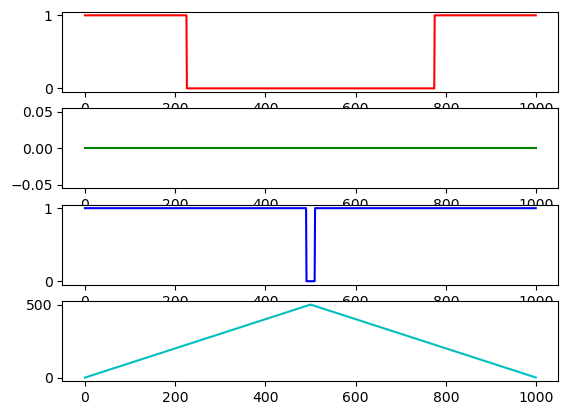

In [114]:
# Generate the PWM signal
pwm_signals = np.zeros((3, 2*tmax), dtype=np.uint32)
ticks = np.zeros((1, 2*tmax), dtype=np.uint32)
tick_values = np.zeros((1, 2*tmax), dtype=np.uint32)  # Array to store tick values

tick = 0
count_up = True
for x in range(2*tmax):
    ticks[0, x] = x
    tick_values[0, x] = tick  # Store tick value
    if tick < phase_u_ticks:
        pwm_signals[0, x] = 1
    if tick < phase_v_ticks:
        pwm_signals[1, x] = 1
    if tick < phase_w_ticks:
        pwm_signals[2, x] = 1

    if count_up:
        tick += 1
        count_up = tick < tmax
    else:
        tick -= 1
        count_up = tick == 0

# Plot the PWM signals
import matplotlib.pyplot as plt

fig = plt.figure()

# Create subplot 1
ax1 = fig.add_subplot(4, 1, 1)
ax1.plot(ticks[0, :], pwm_signals[0, :], 'r')

# Create subplot 2
ax2 = fig.add_subplot(4, 1, 2)
ax2.plot(ticks[0, :], pwm_signals[1, :], 'g')

# Create subplot 3
ax3 = fig.add_subplot(4, 1, 3)
ax3.plot(ticks[0, :], pwm_signals[2, :], 'b')

# Create subplot 4 for tick values
ax4 = fig.add_subplot(4, 1, 4)
ax4.plot(ticks[0, :], tick_values[0, :], 'c')  # Plot tick values

plt.show()


In [115]:
# Compute the switch state transitions within the single PWM cycle
binary_values = []

# Iterate over each column
for i in range(pwm_signals.shape[1]):
  # Convert the column to a binary string and then to an integer
  binary_value = int(''.join(map(str, pwm_signals[:, i])), 2)
  binary_values.append(binary_value)

# Convert the list to a numpy array
binary_values = np.array(binary_values)

# Accumulate the sequence of transitions
unique_transitions = []
for i in range(len(binary_values)):
  if i == 0 or binary_values[i] != binary_values[i-1]:
    unique_transitions.append(binary_values[i])

print(f"Switch State Transitions: {unique_transitions}")
print("U V W")
for transition in unique_transitions:
  binary_string = bin(transition)[2:].zfill(3)
  print(' '.join(binary_string))

# Check if only a single bit has changed between each transition
for i in range(len(unique_transitions)-1):
  if bin(unique_transitions[i] ^ unique_transitions[i+1]).count('1') != 1:
    print(f"ERROR: Invalid transition from {i-1} to {i}")

Switch State Transitions: [5, 1, 0, 1, 5]
U V W
1 0 1
0 0 1
0 0 0
0 0 1
1 0 1
